In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('/content/data.csv', encoding = 'unicode_escape')

**LA MÉTHODE RFM**

Méthode d'analyse de la qualité d'un client selon trois critères.
**La récence** : date du dernier achat ou temps écoulé depuis ;
**la fréquence** : périodicité moyenne des achats sur la période considérée ; 
**la valeur** : montant des achats réalisés par ce client sur la période étudiée.

In [2]:
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom


In [3]:
#On a 8 colonnes et 541 909 lignes
df.shape

(541909, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df.isna().mean()

InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249267
Country        0.000000
dtype: float64

In [6]:
#On a 135 080 transactions pour lesquelles il n'y a pas d'identifiant clients
#On veut pouvoir analyser le comportement des client donc le CustomerID est indispensable
#On supprime les lignes avec valeurs manquantes
df.dropna(inplace=True)
df.shape

(406829, 8)

In [7]:
df.describe().T
#On a des valeurs négatives dans les quantités qui correspondent à des retours ou promotions (mention C devant) et les prix=0
#peuvent être des cadeaux

,count,mean,std,min,25%,50%,75%,max
Quantity,406829.0,12.061303,248.693370,-80995.0,2.00,5.00,12.00,80995.0
UnitPrice,406829.0,3.460471,69.315162,0.0,1.25,1.95,3.75,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.0,13953.00,15152.00,16791.00,18287.0


In [8]:
df[df['Quantity']<0].head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom


In [9]:
df[df['UnitPrice']==0].head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,12/5/2010 14:02,0.0,12647.0,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,12/16/2010 14:36,0.0,16560.0,United Kingdom


In [10]:
#On va modifier le format de la date
df['Date']= pd.to_datetime(df['InvoiceDate'])
#On veut avoir le nombre de jours écoulé depuis la date de la transaction 
df['Days'] = (max(df['Date']) - df['Date']).dt.days
#La transaction de la première ligne a eu lieu il y a 373 jours
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Days
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,2010-12-01 08:26:00,373
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,373
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,2010-12-01 08:26:00,373


In [11]:
print(df['Date'].min(), df['Date'].max())

2010-12-01 08:26:00 2011-12-09 12:50:00


In [12]:
#On va ajouter une colonne MonetaryValue (prix*quantité)
df['MonetaryValue'] = df['UnitPrice']*df['Quantity']
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Days,MonetaryValue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,2010-12-01 08:26:00,373,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,373,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,2010-12-01 08:26:00,373,22.00


- Decriptions (ventes, ca, articles)

In [13]:
# revenue par mois
df_CA_M = df[['Date', 'MonetaryValue']].groupby(pd.Grouper(key='Date', freq='M')).sum() 
df_CA_M = df_CA_M.reset_index()

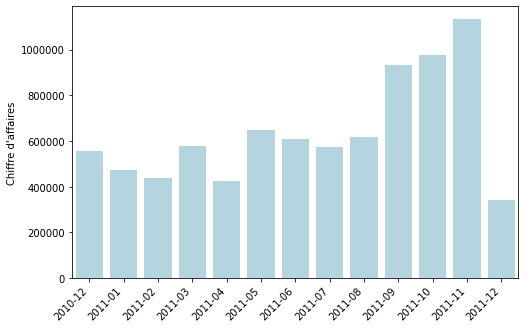

In [14]:
#Visualisation de l'évolution du CA
fig, ax = plt.subplots(figsize = (8,5))
fig = sns.barplot(data=df_CA_M, x='Date', y='MonetaryValue', color='lightblue')
ax.set_xticklabels(labels=df_CA_M['Date'].dt.strftime('%Y-%m'), rotation=45, ha='right')
plt.ticklabel_format(style='plain', axis='y')
ax.set_xlabel('')
ax.set_ylabel('Chiffre d\'affaires')
plt.show()

In [15]:
#Ventes par mois
df_Ventes_M = df[['Date', 'InvoiceNo']].groupby(pd.Grouper(key='Date', freq='M')).InvoiceNo.nunique()
df_Ventes_M = df_Ventes_M.reset_index()

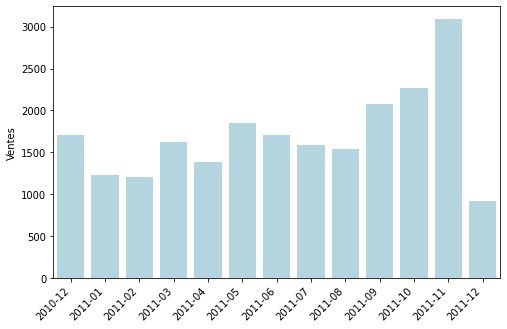

In [16]:
#Visualisation des Ventes
fig, ax = plt.subplots(figsize = (8,5))
fig = sns.barplot(data=df_Ventes_M, x='Date', y='InvoiceNo', color='lightblue')
ax.set_xticklabels(labels=df_Ventes_M['Date'].dt.strftime('%Y-%m'), rotation=45, ha='right')
ax.set_xlabel('')
ax.set_ylabel('Ventes')
plt.show()

In [17]:
#les best sellers'
df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(5).reset_index()

,Description,Quantity
0,WORLD WAR 2 GLIDERS ASSTD DESIGNS,53215
1,JUMBO BAG RED RETROSPOT,45066
2,ASSORTED COLOUR BIRD ORNAMENT,35314
3,WHITE HANGING HEART T-LIGHT HOLDER,34147
4,PACK OF 72 RETROSPOT CAKE CASES,33409


- Modèle RFM

In [18]:
#Modèle RFM
df_rfm = df.groupby('CustomerID').agg({'Days': lambda x:x.min(), # Recency
                                        'CustomerID': lambda x: len(x),  # Frequency
                                        'MonetaryValue': lambda x: x.sum()}) # Monetary Value

df_rfm.rename(columns={'Days': 'recency', 
                         'CustomerID': 'frequency', 
                         'MonetaryValue': 'monetary_value'}, inplace=True)

df_rfm.head(3)

,recency,frequency,monetary_value
CustomerID,,,
12346.0,325,2,0.00
12347.0,1,182,4310.00
12348.0,74,31,1797.24


In [19]:
df_rfm.shape

(4372, 3)

In [20]:
#VERIFICATION. : Pour le client dont l'ID est 12346.0 on peut voir que c'est une commande 
#qui a été retourné (donc valeur monétaire = 0) il y a 325 jours.
df[df['CustomerID']==12346.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Days,MonetaryValue
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom,2011-01-18 10:01:00,325,77183.6
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1/18/2011 10:17,1.04,12346.0,United Kingdom,2011-01-18 10:17:00,325,-77183.6


**LE CLUSTERING K_MEANS**




- Extraction des outliers ou valeurs extrêmes

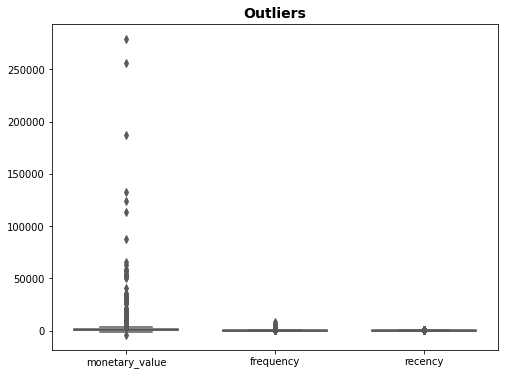

In [21]:
# Visualisation des Outliers ou Valeurs extrêmes

variables = ['monetary_value','frequency','recency']
plt.rcParams['figure.figsize'] = [8,6]
sns.boxplot(data = df_rfm[variables], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers", fontsize = 14, fontweight = 'bold')
print('')

In [22]:
#Pour supprimer identifier les outliers on va utiliser la méthode de l'écart interquartile (IQR)

#supprimer les outliers de la variable monetary_value 

Q1_m = df_rfm.monetary_value.quantile(0.25)
Q3_m = df_rfm.monetary_value.quantile(0.75)
IQR_m = Q3_m - Q1_m
df_rfm = df_rfm[(df_rfm.monetary_value > (Q1_m - 1.5*IQR_m)) & (df_rfm.monetary_value < (Q3_m + 1.5*IQR_m))]

#supprimer les outliers de la variable frequency

Q1_f = df_rfm.frequency.quantile(0.25)
Q3_f = df_rfm.frequency.quantile(0.75)
IQR_f = Q3_f - Q1_f
df_rfm = df_rfm[(df_rfm.frequency > (Q1_f - 1.5*IQR_f)) & (df_rfm.frequency < (Q3_f + 1.5*IQR_f))]

#supprimer les outliers de la variable recency

Q1_r = df_rfm.recency.quantile(0.25)
Q3_r = df_rfm.recency.quantile(0.75)
IQR_r = Q3_r - Q1_r
df_rfm = df_rfm[(df_rfm.recency > (Q1_r - 1.5*IQR_r)) & (df_rfm.recency < (Q3_r + 1.5*IQR_r))]


In [23]:
df_rfm.shape

(3697, 3)

- Standardisation des données 

In [24]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(df_rfm)

In [25]:
df_rfm_stand = pd.DataFrame(X, index=df_rfm.index, columns=df_rfm.columns)

In [26]:
df_rfm_stand.head(3)

,recency,frequency,monetary_value
CustomerID,,,
12346.0,2.136422,-1.070949,-1.041614
12348.0,-0.282050,-0.375498,1.385298
12349.0,-0.821629,0.631707,1.331702


**CLUSTERING KMEANS**

In [27]:
from sklearn.cluster import KMeans
from sklearn import cluster, metrics

#On cherche le nombre "idéal" de clusters ou segment (homogènes)
#"Elbow method"

- Elbow Method

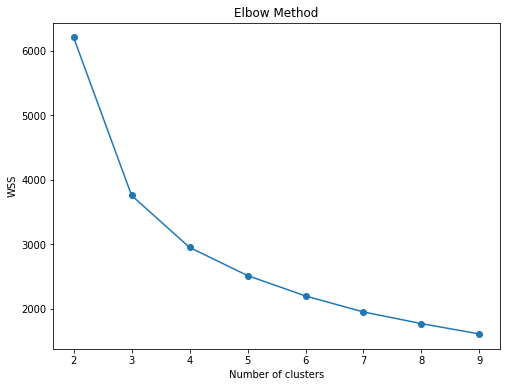

In [28]:
Sum_of_squared_distances = []

for num_clusters in range(2,10) :
    kmeans = KMeans(n_clusters=num_clusters, init='random', random_state=1)
    
    kmeans.fit(df_rfm_stand)
    ssd = kmeans.inertia_ #somme des carrées des variances intra classes
    Sum_of_squared_distances.append(ssd)

plt.plot(range(2,10),Sum_of_squared_distances, marker='o')
plt.xlabel('Number of clusters') 
plt.ylabel('WSS') 
plt.title('Elbow Method')

plt.show()

On retient 4 clusters

- KMEANS avec 4 clusters

In [29]:
# k-means clustering avec 4 clusters
kmeans = KMeans(init='random', n_clusters=3, n_init=1, random_state=1)

# association du clustering aux données
kmeans.fit(df_rfm_stand)

#données normalisées sous forme de dataframe pour le Kmeans
df_rfm_kmeans = pd.DataFrame(df_rfm_stand, index=df_rfm.index, columns=df_rfm.columns)

#clustering kmeans appliqué au dataframe
df_rfm_kmeans['kmeans_clusters'] = kmeans.labels_

In [30]:
df_rfm['clusters'] = kmeans.labels_

In [31]:
df_rfm.head(3)

,recency,frequency,monetary_value,clusters
CustomerID,,,,
12346.0,325,2,0.00,0
12348.0,74,31,1797.24,2
12349.0,18,73,1757.55,1


In [32]:
#les valeurs moyenne de récence, fréquence, valeur monétaire pour chaque clusters ou segments
df_rfm_mean = df_rfm.groupby('clusters').mean().round(decimals=0)
df_rfm_mean

,recency,frequency,monetary_value
clusters,,,
0,255.0,21.0,327.0
1,44.0,110.0,1849.0
2,51.0,34.0,559.0


In [33]:
# Visualisation des différents clusters ou segment clients selon
#la récence, fréquence et valeur monétaire moyenne de chaque groupe
import plotly.graph_objects as go
labels=['Clients Inactifs', 'Meilleurs Clients', 'Nouveaux Clients']

fig = go.Figure(data=[
    go.Bar(name='recency', x=labels, y=[255,44, 51]),
    go.Bar(name='frequency', x=labels, y=[21, 110, 34]),
    go.Bar(name='monetary_value', x=labels, y=[327, 1849, 559])

])

# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

**Segment B : Les meilleurs clients** : tous les indicateurs sont bons, les achats sont récents il y a 44 jours (moyenne), la fréquence d'achat et la valeur monétaire sont très élevé

**Segment C : Les nouveaux clients**, les achats sont récents, la valeur monétaire est élevé

**Segment A : Les clients inactifs**, les achats sont les plus éloignées dans le temps, il y a 255 jours (moyenne), la fréquence d'achat et la valeur monétaire sont les plus faible

In [34]:
df_rfm.head(3)

,recency,frequency,monetary_value,clusters
CustomerID,,,,
12346.0,325,2,0.00,0
12348.0,74,31,1797.24,2
12349.0,18,73,1757.55,1


In [35]:
#CA par les différentes catégories de clients
CA_clusters = df_rfm.groupby('clusters')['monetary_value'].sum().reset_index()

In [36]:
CA_clusters['%CA'] = ((CA_clusters['monetary_value']/CA_clusters['monetary_value'].sum())*100).round()
CA_clusters.head(3)

,clusters,monetary_value,%CA
0,0,318802.890,11.0
1,1,1449600.081,51.0
2,2,1083326.403,38.0


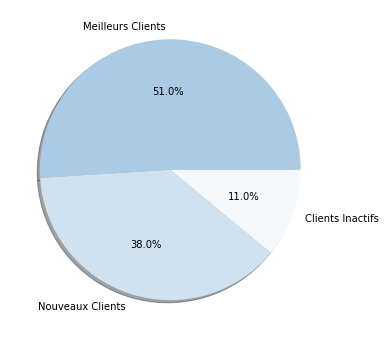

In [37]:
#Visualisation des CA par catégories de clients
valeurs = [51, 38, 11]
Labels = ["Meilleurs Clients","Nouveaux Clients","Clients Inactifs"]
colors=["#abcae4", "#d0e1f0", "#f5f9fc"]
plt.pie(valeurs, labels=Labels,autopct='%1.1f%%', shadow=True, colors=colors)
plt.show()

In [38]:
#Effectifs des différentes catégories de clients
Effectifs_clusters = df_rfm.clusters.value_counts().reset_index().rename(columns={"index": "clusters", "clusters":"effectif"})

In [39]:
Effectifs_clusters["%Total"] = ((Effectifs_clusters["effectif"]/Effectifs_clusters["effectif"].sum())*100).round().astype(str) + '%'
Effectifs_clusters.head(3)

,clusters,effectif,%Total
0,2,1939,52.0%
1,0,974,26.0%
2,1,784,21.0%


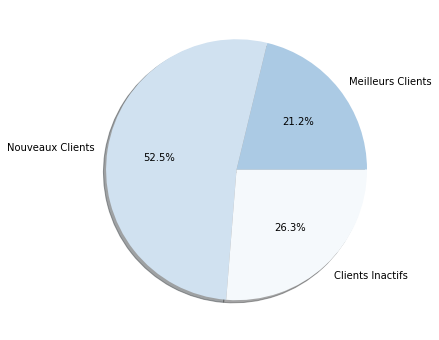

In [40]:
#visualisation des effectifs
valeursx = [21, 52, 26]
Labelsx = ["Meilleurs Clients","Nouveaux Clients","Clients Inactifs"]
colorsx=["#abcae4", "#d0e1f0", "#f5f9fc"]
plt.pie(valeursx, labels=Labelsx,autopct='%1.1f%%', shadow=True, colors=colorsx)
plt.show()